# Puzzle

### Consigna
Hay 4 bolas negras en una bolsa. Saco 2, las pinto de blanco y las vuelvo a meter en la bolsa. Repito el proceso: saco otras 2 bolas (al azar) y las pinto de blanco, hasta haber pintado las 4.

¿Cual es el valor esperado de ese proceso? Es decir, si $X$ es una variable aleatoria que representa la cantidad de veces que pinto 2 bolas hasta haber pintado las 4, calcular $\mathbf{E}(X)$.

### Solución

Podemos pensar el problema como una cadena de Markov, donde tenemos tres estados posibles: `Dos blancas`, `Tres blancas` y `Cuatro blancas`.

In [1]:
import networkx as nx

estados = ['Cuatro negras', 'Dos blancas', 'Tres blancas', 'Cuatro blancas']
G = nx.MultiDiGraph()
G.add_nodes_from(estados)

Las transiciones entre los estados estan dadas por las siguientes formulas:

$$
\begin{align}
&Cuatro\ negras \rightarrow Dos\ blancas \qquad 1 \\
&Dos\ blancas \rightarrow Dos\ blancas \qquad \frac{2\choose 2}{4\choose 2} = \frac{1}{6} \\
&Dos\ blancas \rightarrow Tres\ blancas \qquad \frac{{2\choose 1} {2\choose 1}}{4\choose 2} = \frac{2}{3} \\
&Dos\ blancas \rightarrow Cuatro\ blancas \qquad \frac{2\choose 2}{4\choose 2} = \frac{1}{6}\\
&Tres\ blancas \rightarrow Cuatro\ blancas \qquad \frac{{3\choose 1} {1\choose 1}}{4\choose 2} = \frac{1}{2}\\
&Tres\ blancas \rightarrow Cuatro\ blancas \qquad \frac{3\choose 2}{4\choose 2} = \frac{1}{2}\\
&Cuatro\ blancas \rightarrow Cuatro\ blancas \qquad 1
\end{align}
$$

In [2]:
# Agrego las transiciones
G.add_edge('Cuatro negras', 'Dos blancas', label=1)
G.add_edge('Dos blancas', 'Dos blancas', label=0.166)
G.add_edge('Dos blancas', 'Tres blancas', label=0.666)
G.add_edge('Dos blancas', 'Cuatro blancas', label=0.166)
G.add_edge('Tres blancas', 'Tres blancas', label=0.5)
G.add_edge('Tres blancas', 'Cuatro blancas', label=0.5)
G.add_edge('Cuatro blancas', 'Cuatro blancas', label=1)

En el siguiente gráfico podemos ver la cadena de Markov.

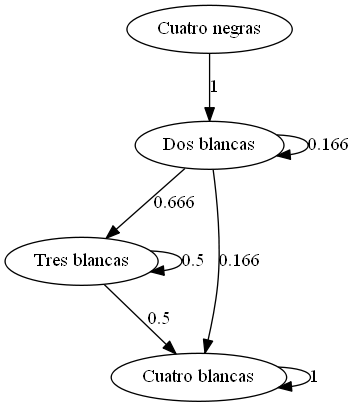

In [3]:
from IPython.display import Image, display
from networkx.drawing.nx_pydot import to_pydot

pdot = to_pydot(G)
display(Image(pdot.create_png()))

La matriz de transiciones es la siguiente:

$$
\large
\mathbf{P} =
\begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & \frac{1}{6} & \frac{2}{3} & \frac{1}{6} \\
0 & 0 & \frac{1}{2} & \frac{1}{2} \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

El vector inicial $x_0$ (cuatro pelotas negras):

$$
\large
\mathbf{x_0} = 
\begin{bmatrix}
1 & 0 & 0 & 0
\end{bmatrix}
$$

En un proceso de Markov, el estado actual sólo depende del estado anterior.

$$
\large
\begin{align}
x_1 &= x_0 \cdot A \\
x_2 &= x_1 \cdot A = x_0 \cdot A^2 \\
\vdots \\
x_n &= x_0 \cdot A^n
\end{align}
$$

Observamos que hay un [estado absorvente](https://en.wikipedia.org/wiki/Absorbing_Markov_chain), el que termina el juego: 'Cuatro blancas'. La cantidad de pasos hasta llegar al estado absorvente sigue una [distribución discreta de tipo fase](https://en.wikipedia.org/wiki/Discrete_phase-type_distribution).

Visto esto, la matriz de transición queda determinada por la submatriz superior izquierda $\mathbf{T}$.

$$
\large
\mathbf{P} =
\begin{bmatrix}
\mathbf{T} & \mathbf{T_0} \\
0 & 1
\end{bmatrix}
$$

El valor esperado $\mathbf{E}(X)$ lo podemos interpretar como la suma los tiempos hasta el estado absorvente.

$$
\large
\mathbf{E}(X) = \mathbf{x_0} \cdot (I + T + T^2 + T^3 + \dots) \cdot \mathbf{1}
$$

No es difícil [demostrar](https://math.stackexchange.com/questions/867768/geometric-series-of-matrices) que la serie geométrica $I + T + T^2 + T^3 + \dots$ converge a $(I - T)^{-1}$. Con lo cual tenemos:

$$
\large
\mathbf{E}(X) = \mathbf{x_0} \cdot (\mathbf{I} - \mathbf{T})^{-1} \cdot \mathbf{1}
$$

In [10]:
import numpy as np
from numpy.linalg import inv

T = np.array([[0., 1., 0.], [0., 1/6, 2/3], [0., 0., 0.5]])
x_0 = np.array([1., 0., 0.])

# Matriz Identidad de 3x3
I = np.eye(3)

# Vector de unos: [1, 1, 1]
ones = np.ones((3,))

# Calculamos la suma geometrica (I - T)^(-1) * 1
geometric_sum = inv(I - T).dot(ones)

# Finalmente calculamos el valor esperado
exp_value = x_0.dot(geometric_sum)

print("El valor esperado es = ", exp_value)

El valor esperado es =  3.8


### Simulación

Para confirmar el resultado, realizamos una simulación.

In [9]:
# Simulacion
# Bola negra := False
# Bola blanca := True

num_simulaciones = 100000
acumulado = 0 # Contamos la cantidad de pasos totales para aproximar E(X) = acumulado / num_simulaciones

for i in range(num_simulaciones):
    bolas = [False, False, False, False] # 4 bolas negras
    
    # Mientras no sean todas blancas, saco 2 al azar y las pinto
    steps = 0
    while not all(bolas):
        steps = steps + 1
        i, j = np.random.choice(4, size=2, replace=False)
        bolas[i] = True
        bolas[j] = True
    
    acumulado = acumulado + steps
    
print("El valor esperado es aproximadamente = ", acumulado / num_simulaciones)     
        
    

El valor esperado es aproximadamente =  3.81049
